In [1]:
#setup
data_dir='../../Data/Weather'
file_index='BSSSBSBS'
meas='TOBS'

# Reconstruction using top eigen-vectors
For measurement = {{meas}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [2]:
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.11.3 	required version>=1.12.0 ******* Update Version ******
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [28]:
from pyspark import SparkContext
sc.stop()

#sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])
#sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])


from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





AttributeError: 'NoneType' object has no attribute 'sc'

## Read Statistics File

In [4]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [5]:
#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==meas)
df.show(5)

+-----------------+------------------+------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+-------------------+-----------+-----------+------+--------------------+------+
|          coeff_1|           coeff_2|           coeff_3|elevation|   label|latitude|longitude|measurement|             res_1|             res_2|             res_3|           res_mean|    station|  total_var|undefs|              vector|  year|
+-----------------+------------------+------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+-------------------+-----------+-----------+------+--------------------+------+
|880.8829687048515|-724.6419048217356|213.44655383234524|     44.2|BSSSBSBS| 31.0383| -85.8708|       TOBS|0.7492952409450391|0.5808434136132298|0.5654491957837556| 0.3032845696928994|USC00013251|1.0341558E7|     1|[10 5A 00 00 90 D...|1979.0|
|868.3114965309734|-557.

### Plot Mean and Eigenvecs

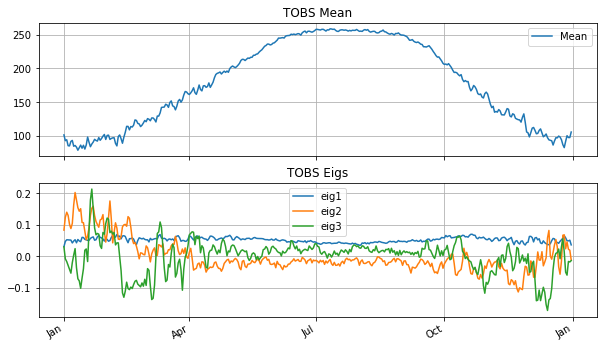

In [6]:
m=meas
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

### plot the percent of residual variance on average

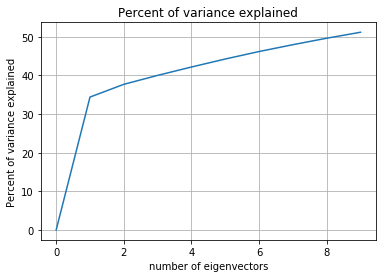

In [7]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');


### How well-explained are the vectors in this collection?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [8]:
# A function for plotting the CDF of a given feature
def plot_CDF(df,feat):
    rows=df.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)))
    while len(vals)< len(P):
        vals=[vals[0]]+vals
    plot(vals,P)
    title('cumulative distribution of '+feat)
    ylabel('fraction of instances')
    xlabel(feat)
    grid()
    

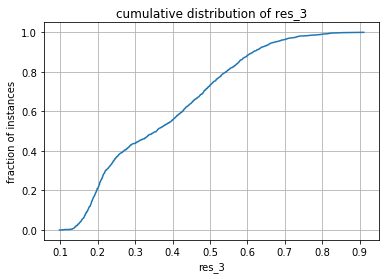

In [9]:
plot_CDF(df,'res_3')

In [10]:
rows=df.rdd.map(lambda row:(row.station,row.year,unpackArray(row['vector'],np.float16))).collect()
rows[0][:2]

(u'USC00013251', 1979.0)

In [11]:
days=set([r[1] for r in rows])
miny=min(days)
print miny
maxy=max(days)
print maxy
record_len=int((maxy-miny+1)*365)
record_len

1901.0
2012.0


40880

In [12]:
## combine the measurements for each station into a single long array with an entry for each day of each day
All={}  # a dictionary with a numpy array for each day of each day
i=0
for station,day,vector in rows:
    i+=1; 
    # if i%1000==0: print i,len(All)
    if not station in All:
        a=np.zeros(record_len)
        a.fill(np.nan)
        All[station]=a
    loc = int((day-miny)*365)
    All[station][loc:loc+365]=vector

In [13]:
from datetime import date
d=datetime.date(int(miny), month=1, day=1)
start=d.toordinal()
dates=[date.fromordinal(i) for i in range(start,start+record_len)]

In [14]:
for station in All:
    print station, np.count_nonzero(~np.isnan(All[station]))

USC00012813 25941
USC00011084 29444
USC00013035 7228
USC00012675 13010
USC00011080 12573
USC00012758 17958
USC00012670 3171
USC00086836 7896
USC00016988 24568
USC00013251 12703
USC00085850 5000
USC00010402 16864
USC00013255 10105
USC00228382 6522
USC00010407 4307
USC00086999 3970
USC00085793 20908
USC00086240 22279
USC00226718 17567
USC00010583 29861
USC00014822 7512
USC00081984 4648
USC00086129 2767
USC00015483 2905
USC00080875 3153
USC00011685 6501
USC00086842 14178
USC00086841 7473
USC00011566 20885
USC00010252 22192
USC00017733 4839
USC00014193 10312
USC00013105 16100
USC00011803 17363
USC00012172 12729
USC00082220 32103
USC00089417 3486


In [15]:
rows=df.rdd.map(lambda row:(row.station,row.latitude, row.longitude,unpackArray(row['vector'],np.float16))).collect()

In [16]:
import pandas as pd

In [17]:
data=pd.DataFrame(rows, columns=['station','latitude','longitude','vector'])
data=data.drop('vector',1)

In [18]:
data=data.drop_duplicates()

In [19]:
data=data.sort_values(by=['station'], ascending=True)

In [20]:
data.shape

(37, 3)

In [21]:
stations=data[(data['latitude']<30.79)]
stations_1=stations[stations['latitude']>30.51]
stations_2=stations_1[stations_1['longitude']>-88.3]
stations_3=stations_2[stations_2['longitude']<-87.97]

In [22]:
stations_3

,station,latitude,longitude
28,USC00015483,30.6833,-88.0333
251,USC00017733,30.7000,-88.1667


In [23]:
stations_1=data.iloc[30:35]
stations_2=data.iloc[90:101]
stations_3=pd.concat([stations_1,stations_2])
stations_3

,station,latitude,longitude
305,USC00086836,30.1667,-85.7000
285,USC00086841,30.1667,-85.7000
34,USC00086842,30.2492,-85.6606
674,USC00086999,30.5300,-87.1986
225,USC00089417,30.6333,-85.5833


In [24]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

In [25]:
min_lat,max_lat,min_long,max_long = box = (30.51, 
                                           30.79, 
                                           -88.3, 
                                           -87.97)

In [26]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in stations.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    #_count=row['count(station)']
    #_coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(6+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4)
    circles.append(c)
    m.add_layer(c)
m    

In [27]:
plot(dates,All['USW00013846']);

KeyError: 'USW00013846'

In [27]:
Stations=sorted(All.keys())
A=[]
for station in Stations:
    A.append(All[station])

day_station_table=np.hstack([A])
print shape(day_station_table)

(37, 40880)


In [29]:
Stations

[u'USC00010252',
 u'USC00010402',
 u'USC00010407',
 u'USC00010583',
 u'USC00011080',
 u'USC00011084',
 u'USC00011566',
 u'USC00011685',
 u'USC00011803',
 u'USC00012172',
 u'USC00012670',
 u'USC00012675',
 u'USC00012758',
 u'USC00012813',
 u'USC00013035',
 u'USC00013105',
 u'USC00013251',
 u'USC00013255',
 u'USC00014193',
 u'USC00014822',
 u'USC00015483',
 u'USC00016988',
 u'USC00017733',
 u'USC00080875',
 u'USC00081984',
 u'USC00082220',
 u'USC00085793',
 u'USC00085850',
 u'USC00086129',
 u'USC00086240',
 u'USC00086836',
 u'USC00086841',
 u'USC00086842',
 u'USC00086999',
 u'USC00089417',
 u'USC00226718',
 u'USC00228382']

In [30]:
NN[NN>0]

NameError: name 'NN' is not defined

(1512560,) (481021,) (466967,)


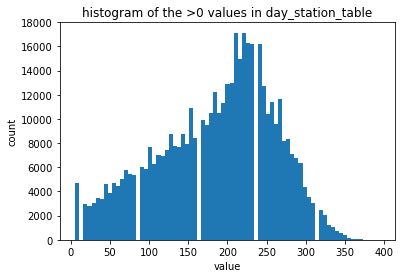

In [31]:
RT=day_station_table
F=RT.flatten()
NN=F[~np.isnan(F)]
NZ=NN[NN>0]
print shape(F),shape(NN),shape(NZ)

hist(NZ,bins=75);
title('histogram of the >0 values in day_station_table')
xlabel('value')
ylabel('count')

In [32]:
def RMS(Mat):
    return np.sqrt(np.nanmean(Mat**2))

mean_by_day=np.nanmean(day_station_table,axis=0)
mean_by_station=np.nanmean(day_station_table,axis=1)
tbl_minus_day = day_station_table-mean_by_day
tbl_minus_station = (day_station_table.transpose()-mean_by_station).transpose()

print 'total RMS                   = ',RMS(day_station_table)
print 'RMS removing mean-by-station= ',RMS(tbl_minus_station)
print 'RMS removing mean-by-day   = ',RMS(tbl_minus_day)

total RMS                   =  197.123039986
RMS removing mean-by-station=  79.6144476689
RMS removing mean-by-day   =  34.439263415


/Users/laurawilke/anaconda3/envs/py27_2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [33]:
#Normalize rows of RT to have norm 1
Len=sqrt(np.nansum(tbl_minus_day**2,axis=1))
NRT=(tbl_minus_day.transpose()/Len).transpose()

In [34]:
K=5  # the number of time-shifts we consider
Middle=K/2 # the index (among K) of the zero-time-shift
n,m=RT.shape
TK=np.empty([n*K,m-K],dtype=numpy.float64)

#create the shifts
for i in range(K):
    TK[i::K,:]=NRT[:,i:-K+i]

#zero Nan entries and indicate them in a separate matrix
TKnan=np.isnan(TK)
TK[TKnan]=0
TK1nan=1-TKnan*1

TT=NRT[:,Middle:-Middle-1]
TTnan=np.isnan(TT)
TT1nan=1-TTnan*1
TT[TTnan]=0
print 'shape of sequence matrix (TT) %s, shape of matrix with %d shifts (TK) %s'%\
    (str(TT.shape),K,str(TK.shape))
#print sum(TK1nan,axis=1)
#print sum(TT1nan)

shape of sequence matrix (TT) (37, 40875), shape of matrix with 5 shifts (TK) (185, 40875)


In [35]:
Prod=np.dot(TK,TT.transpose())
print shape(Prod)
print sum(np.isnan(Prod.flatten()))

(185, 37)
0


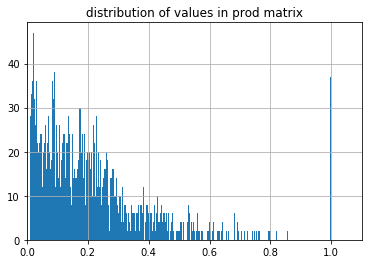

In [36]:
hist(Prod[Prod>0.01].flatten(),bins=300);
xlim([0.0,1.1])
title('distribution of values in prod matrix')
grid()
#showmat(ProdMean[:100,:100].transpose())

In [37]:
n,m

(37, 40880)

In [38]:
_shift=np.empty([n,n])
_max=np.empty([n,n])
for i in range(n):
    Slice=Prod[i*K:(i+1)*K,:]
    _shift[i,:]=np.argmax(Slice,axis=0)  #find best shift
    _max[i,:]=np.max(Slice,axis=0) #find max correlation

In [39]:
def showmat(mat):
    fig,axes=plt.subplots(1,1,figsize=(10,10))
    axes.matshow(mat)

In [40]:
_max[_max>1.]

array([ 1.,  1.,  1.,  1.,  1.,  1.])

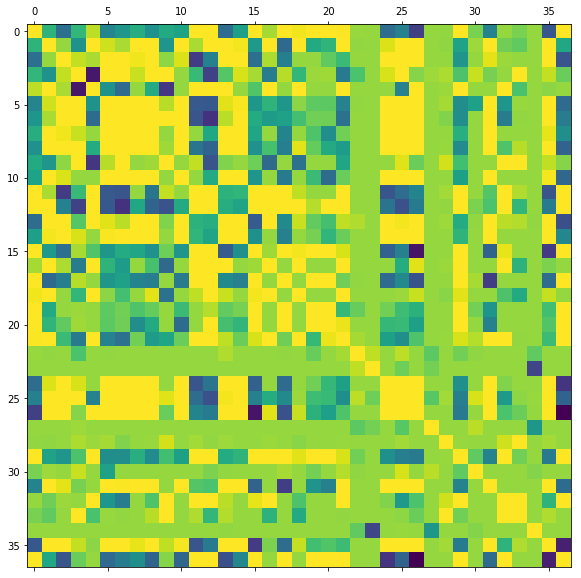

In [41]:
_max2=_max*10.
_max2[_max2>1.]=1.
showmat(_max2)
#showmat(_max*(_max>0.2))

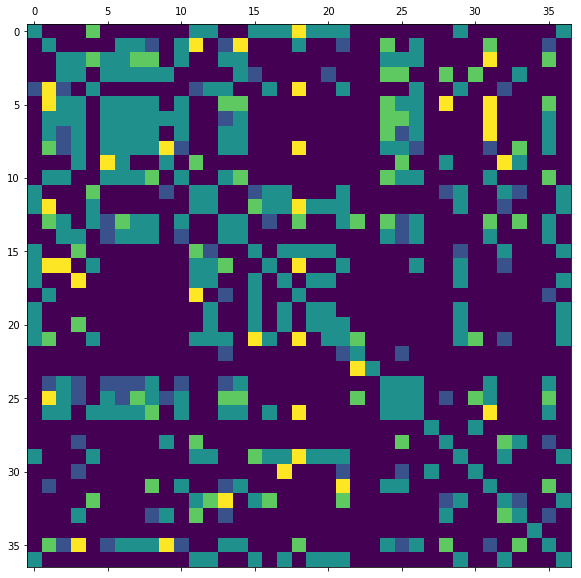

In [42]:
_Sshift=_shift*(_max>0.01)
showmat(_Sshift)

In [43]:
print min(_Sshift.flatten()),max(_Sshift.flatten())

0.0 4.0


[ 1.16658692  0.32492073  0.11270434  0.0791886   0.05611172]
[ 0.53634295  0.14938359  0.05181626  0.03640727  0.02579759]
[ 0.53634295  0.68572655  0.73754281  0.77395008  0.79974767]


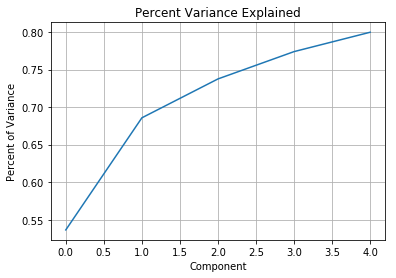

In [44]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5, svd_solver='full')
pca.fit(_max)     
print(pca.explained_variance_)
Var_explained=pca.explained_variance_ratio_
print (Var_explained)
print cumsum(Var_explained)
plot(cumsum(Var_explained))
title('Percent Variance Explained')
ylabel('Percent of Variance')
xlabel('Component')
grid()

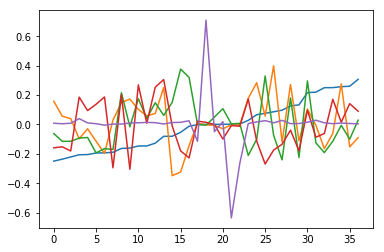

In [45]:
L=list(pca.components_.transpose())
X=sorted(L,key=lambda x:x[0]) 
plot(X);
#(key=lambda x:x[0])

In [46]:
pca.components_

array([[  2.50491510e-01,  -8.09315387e-02,  -1.89492071e-01,
         -8.05554235e-02,   8.61563624e-02,  -1.94276039e-01,
         -1.93452699e-01,  -1.27427472e-01,  -2.04904420e-01,
         -5.34558564e-02,  -1.46888994e-01,   2.16543272e-01,
          2.56830684e-01,  -1.60621945e-01,  -1.46300721e-01,
          2.59983103e-01,   6.62005295e-02,   2.49965784e-01,
          2.77549520e-02,   9.68136801e-02,   1.33071988e-01,
          1.26360170e-01,  -1.43490898e-03,   2.25924775e-03,
         -2.21498124e-01,  -2.06295032e-01,  -2.49725355e-01,
          3.23350341e-03,   6.33670778e-04,   2.19600843e-01,
          6.29601799e-04,  -1.63197346e-01,   7.54499645e-02,
         -1.21804559e-02,   3.05893463e-04,  -2.36328811e-01,
          3.06884917e-01],
       [ -6.16026056e-02,   2.51117283e-01,   2.92953945e-02,
         -3.48740117e-01,   3.98778442e-01,  -1.14134407e-01,
         -1.96523969e-01,   7.44405163e-02,  -2.95745178e-02,
         -3.23916644e-01,   1.02058493e-01,

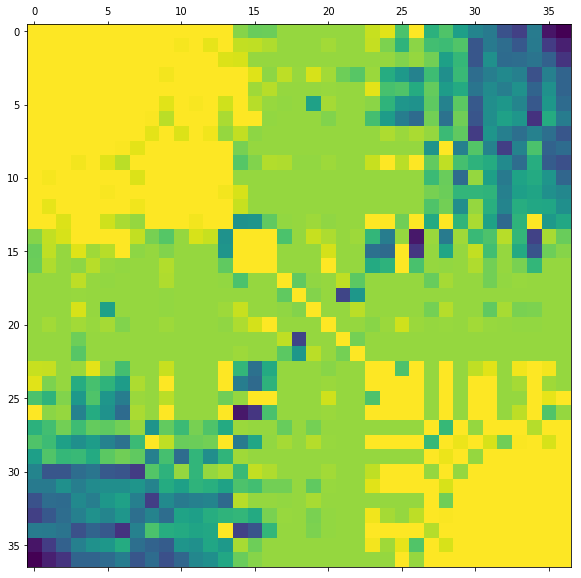

In [47]:
order=np.argsort(pca.components_[0,:])
_max_reord=_max[order,:]
_max_reord=_max_reord[:,order]
_max2=_max_reord*10.
_max2[_max2>1.]=1.
showmat(_max2)

In [48]:
len(_max2)

37

(5, 37)


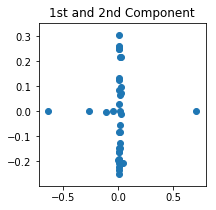

In [49]:
comp_=pca.components_
figure(figsize=(3,3))
print shape(comp_)
scatter(comp_[4,:],comp_[0,:]);
title('1st and 2nd Component')